# Предобработка

In [41]:
from PIL import Image
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score
from tensorflow import keras
from tensorflow.keras.applications import Xception

In [42]:
class_names = os.listdir('./data')
for i, name in enumerate(class_names):
    print(f'Класс {name} = {i}')
num_classes = len(class_names)
class_names = dict(zip(class_names, list(range(num_classes))))

Класс dehiscence = 0
Класс insect_bite = 1
Класс rat_bite = 2


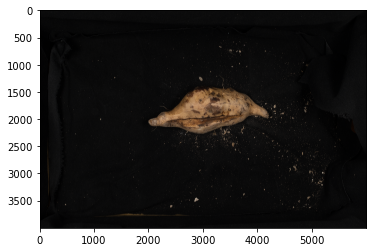

Размер исходных изображений 6000x4000


In [43]:
img = Image.open('./data/dehiscence/D-00001.png')
plt.imshow(img)
plt.show()
w, h = img.size
print(f'Размер исходных изображений {w}x{h}')

Обрезаем изображения, уменьшаем их размер до подходящего для нейросети и переводим в численный вид

In [44]:
data = pd.DataFrame(columns=['img_array', 'cat'])
    
for dir_ in os.listdir('./data'):     
    for im_path in os.listdir(f'./data/{dir_}'):
        im = Image.open(f'./data/{dir_}/{im_path}')
        im_cropped = im.crop((1500, 500, w - 1500, h - 500))
        im_resized = im_cropped.resize((299, 299))
        
        arr = tf.keras.utils.img_to_array(im_resized)        
        data = pd.concat([data, pd.DataFrame([{'img_array':arr, 'cat':class_names[dir_]}])], ignore_index=True)

In [45]:
data

,img_array,cat
0,"[[[7.0, 7.0, 8.0], [7.0, 7.0, 7.0], [7.0, 7.0,...",0
1,"[[[5.0, 5.0, 6.0], [6.0, 6.0, 6.0], [6.0, 7.0,...",0
2,"[[[7.0, 7.0, 7.0], [6.0, 6.0, 6.0], [8.0, 8.0,...",0
3,"[[[6.0, 6.0, 6.0], [6.0, 6.0, 7.0], [7.0, 7.0,...",0
4,"[[[10.0, 10.0, 11.0], [10.0, 10.0, 11.0], [10....",0
...,...,...
122,"[[[8.0, 8.0, 8.0], [8.0, 8.0, 8.0], [8.0, 8.0,...",2
123,"[[[7.0, 7.0, 7.0], [7.0, 7.0, 7.0], [9.0, 9.0,...",2
124,"[[[8.0, 8.0, 8.0], [8.0, 8.0, 9.0], [8.0, 8.0,...",2
125,"[[[8.0, 8.0, 8.0], [8.0, 8.0, 8.0], [7.0, 7.0,...",2


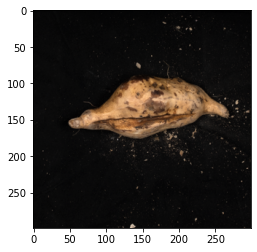

Размер преобразованных изображений (299, 299)


In [46]:
img = tf.keras.utils.array_to_img(data.iloc[0]['img_array'])
plt.imshow(img)
plt.show()
print(f'Размер преобразованных изображений {img.size}')

Перемешиваем сэмплы

In [47]:
tf.keras.utils.set_random_seed(42)

In [48]:
data_ = data.sample(frac=1, random_state=42)

Создаем массивы Х и у

In [49]:
X = np.concatenate(data_.img_array.to_numpy()).reshape(127,299,299,3)
y = tf.keras.utils.to_categorical(data_.cat.to_numpy(), num_classes)

Создаем датагенератор

In [50]:
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

In [51]:
train_generator = datagen.flow(X, y, subset='training')

In [52]:
validation_generator = datagen.flow(X, y, subset='validation')

# Спецификация модели
Будет использоваться встроенная в keras модель Xception\
В документации к ней написан рекомендуемый размер изображения

In [53]:
base_model = Xception(input_shape = (299, 299, 3), include_top = False)


METRICS = [
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    tfa.metrics.F1Score(num_classes=3, average="macro",name = 'F1Score'),
]


from keras import optimizers, callbacks, regularizers 

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(3, activation='softmax')(x)
model = tf.keras.models.Model(base_model.input, x) 
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = [METRICS]) 

In [54]:
model_dir = "./model"
file_name = "model"
modelfile = f"{model_dir}/{file_name}.h5"
logfile = f"{model_dir}/{file_name}.log"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_chpo = keras.callbacks.ModelCheckpoint(modelfile, save_best_only=True)
csv_logger = keras.callbacks.CSVLogger(logfile)
callbacks_list = [model_chpo,csv_logger]

# Обучение модели

In [55]:
hist = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs =15,
    batch_size=32,
    callbacks=callbacks_list) 

Epoch 1/15
4/4 [==============================] - 74s 15s/step - loss: 1.0067 - precision: 0.6471 - recall: 0.1078 - F1Score: 0.4988 - val_loss: 0.9446 - val_precision: 0.6667 - val_recall: 0.1600 - val_F1Score: 0.2162
Epoch 2/15
4/4 [==============================] - 68s 21s/step - loss: 0.5006 - precision: 0.9639 - recall: 0.7843 - F1Score: 0.8080 - val_loss: 0.8842 - val_precision: 1.0000 - val_recall: 0.2400 - val_F1Score: 0.3311
Epoch 3/15
4/4 [==============================] - 67s 16s/step - loss: 0.2738 - precision: 0.9792 - recall: 0.9216 - F1Score: 0.9737 - val_loss: 0.8803 - val_precision: 0.6111 - val_recall: 0.4400 - val_F1Score: 0.2162
Epoch 4/15
4/4 [==============================] - 67s 16s/step - loss: 0.1550 - precision: 1.0000 - recall: 0.9902 - F1Score: 0.9871 - val_loss: 0.8940 - val_precision: 0.5714 - val_recall: 0.4800 - val_F1Score: 0.2162
Epoch 5/15
4/4 [==============================] - 65s 15s/step - loss: 0.0728 - precision: 1.0000 - recall: 1.0000 - F1Score

# Графики

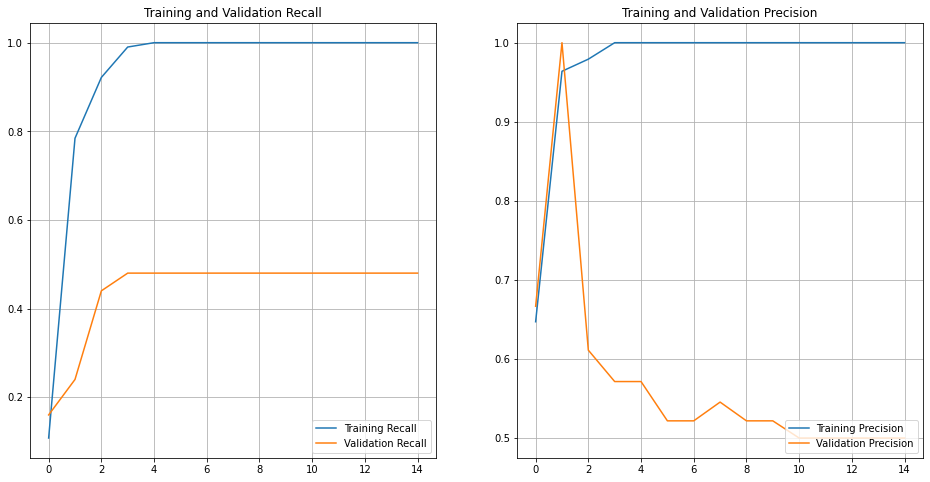

In [56]:
def plot_recallandPrecision(file_name):
    log_data = pd.read_csv(file_name)
    epoch = log_data['epoch'].to_numpy()
    Recall = log_data['recall'].to_numpy()
    val_Recall = log_data['val_recall'].to_numpy()
    Precision = log_data['precision'].to_numpy()
    val_Precision = log_data['val_precision'].to_numpy()
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.plot(epoch, Recall, label='Training Recall') 
    plt.plot(epoch, val_Recall, label='Validation Recall') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation Recall')
    plt.subplot(1, 2, 2)
    plt.grid()
    plt.plot(epoch, Precision, label='Training Precision') 
    plt.plot(epoch, val_Precision, label='Validation Precision') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation Precision')
    return plt.show()
plot_recallandPrecision(logfile) 

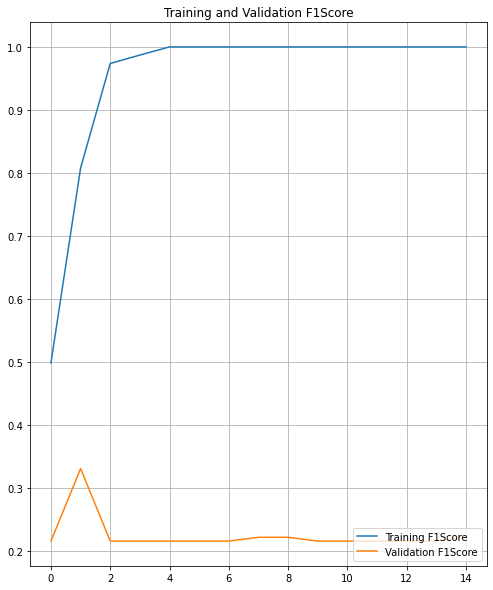

In [57]:
def plot_f1(file_name):
    log_data = pd.read_csv(file_name)
    epoch = log_data['epoch'].to_numpy()
    F1Score = log_data['F1Score'].to_numpy()
    val_F1Score = log_data['val_F1Score'].to_numpy()
    plt.figure(figsize=(18, 10))
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.plot(epoch, F1Score, label='Training F1Score') 
    plt.plot(epoch, val_F1Score, label='Validation F1Score') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation F1Score')
    return plt.show()
plot_f1(logfile)


# Аугментация

In [72]:
aug_datagen = ImageDataGenerator(rotation_range=3,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

In [73]:
train_generator = aug_datagen.flow(X, y, subset='training')
validation_generator = aug_datagen.flow(X, y, subset='validation')

In [74]:
base_model = Xception(input_shape = (299, 299, 3), include_top = False)


METRICS = [
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    tfa.metrics.F1Score(num_classes=3, average="macro",name = 'F1Score'),
]


from keras import optimizers, callbacks, regularizers 

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(3, activation='softmax')(x)
model_aug = tf.keras.models.Model(base_model.input, x) 
model_aug.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = [METRICS]) 

In [75]:
model_dir = "./model_aug"
file_name = "model_aug"
modelfile = f"{model_dir}/{file_name}.h5"
logfile = f"{model_dir}/{file_name}.log"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_chpo = keras.callbacks.ModelCheckpoint(modelfile, save_best_only=True)
csv_logger = keras.callbacks.CSVLogger(logfile)
callbacks_list = [model_chpo,csv_logger]

In [76]:
hist = model_aug.fit(
    train_generator,
    validation_data = validation_generator,
    epochs =15,
    batch_size=32,
    callbacks=callbacks_list) 

Epoch 1/15
4/4 [==============================] - 81s 17s/step - loss: 1.0761 - precision: 0.7500 - recall: 0.0882 - F1Score: 0.3602 - val_loss: 0.9226 - val_precision: 0.3333 - val_recall: 0.0400 - val_F1Score: 0.4162
Epoch 2/15
4/4 [==============================] - 70s 22s/step - loss: 0.8459 - precision: 0.9455 - recall: 0.5098 - F1Score: 0.5052 - val_loss: 0.9195 - val_precision: 0.2500 - val_recall: 0.0400 - val_F1Score: 0.2889
Epoch 3/15
4/4 [==============================] - 65s 15s/step - loss: 0.7018 - precision: 0.9412 - recall: 0.6275 - F1Score: 0.6464 - val_loss: 0.9026 - val_precision: 0.5714 - val_recall: 0.1600 - val_F1Score: 0.3823
Epoch 4/15
4/4 [==============================] - 65s 20s/step - loss: 0.5010 - precision: 0.9737 - recall: 0.7255 - F1Score: 0.7485 - val_loss: 0.8541 - val_precision: 0.6667 - val_recall: 0.3200 - val_F1Score: 0.2909
Epoch 5/15
4/4 [==============================] - 64s 15s/step - loss: 0.3876 - precision: 0.9524 - recall: 0.7843 - F1Score

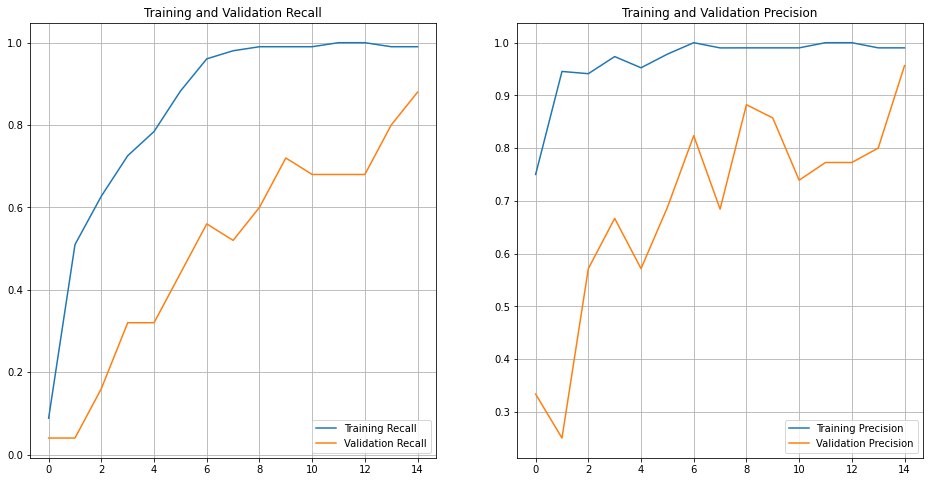

In [77]:
plot_recallandPrecision(logfile) 

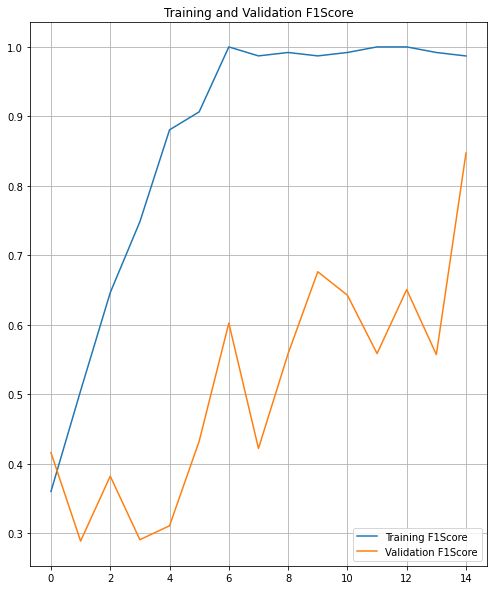

In [78]:
plot_f1(logfile)